# CO2 Rate Switchpoint Analysis

In [3]:
%matplotlib inline
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import pymc3 as pm

from scipy.optimize import fmin_powell

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [4]:
# Original data from: http://esrl.noaa.gov/gmd/ccgg/trends/global.html
data = pd.read_csv('data/co2_rate.csv')

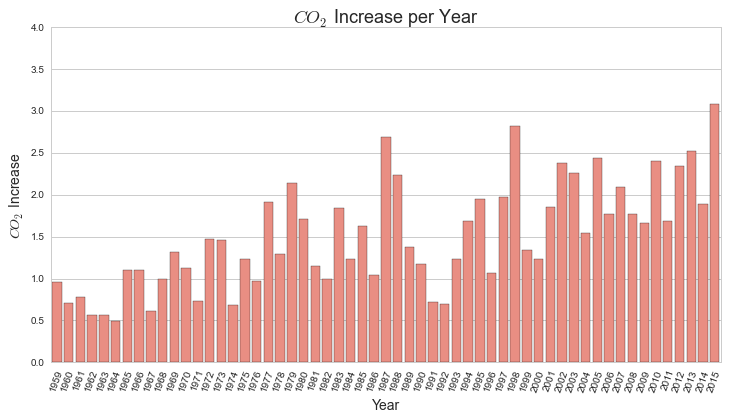

In [5]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=70)
sns.barplot(x='year', y='ppm_per_year', data=data, color='salmon')
plt.ylim((0,4))
plt.ylabel('$CO_2$ Increase', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title('$CO_2$ Increase per Year', fontsize=18)
plt.show()

In [6]:
year = np.arange(1959,2016)

In [7]:
with pm.Model() as model:
    
    # prior for distribution of switchpoint year
    switchpoint = pm.DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1980)
    
    # prior for pre- and post-switch intercept
    a_0 = pm.Normal('a_0', 0, 1)
    a_1 = pm.Normal('a_1', 0, 1)    
    
    # prior for pre- and post-switch slope
    b_0 = pm.Normal('b_0', 0, 0.1)
    b_1 = pm.Normal('b_1', 0, 0.1)
    
    # priors for sigma
#     s = pm.Uniform('s', 0.0, 0.1)
#     s_0 = pm.HalfCauchy('s_0', 1, testval=0.5)
#     s_1 = pm.HalfCauchy('s_1', 1, testval=0.5)
    
    # Assign slopes to appropriate pre- and post-switchpoint locations
    intercept = pm.switch(switchpoint >= year, a_0, a_1)
    slope = pm.switch(switchpoint >= year, b_0, b_1)
#     sigma = pm.switch(switchpoint >= year, s_0, s_1)
    
    # Data likelihood
    y_est = intercept + slope * data['year']
    co2_rate = pm.Normal('co2_rate', mu=y_est , sd=0.01, observed=data['ppm_per_year'])

In [8]:
n = 10000
with model:
#     start = pm.find_MAP(fmin=fmin_powell)
    trace = pm.sample(10000, step=pm.Metropolis())
    start = trace[-1]
    step1 = pm.NUTS([a_0, a_1, b_0, b_1], scaling=start)
    step2 = pm.Metropolis([switchpoint])
    trace = pm.sample(n, step=[step1, step2], start=start)

TypeError: expected type_num 9 (NPY_INT64) got 7
Apply node that caused the error: Elemwise{Composite{(i0 + (i1 * sqr((i2 - (Switch(GE(i3, i4), i5, i6) + (Switch(GE(i3, i4), i7, i8) * i9))))))}}(TensorConstant{(1L,) of 7..7246322632}, TensorConstant{(1L,) of -10000.0}, TensorConstant{[ 0.96  0....89  3.09]}, InplaceDimShuffle{x}.0, TensorConstant{[1959 1960..2014 2015]}, InplaceDimShuffle{x}.0, InplaceDimShuffle{x}.0, InplaceDimShuffle{x}.0, InplaceDimShuffle{x}.0, TensorConstant{[ 1959.  1..4.  2015.]})
Toposort index: 9
Inputs types: [TensorType(float64, (True,)), TensorType(float64, (True,)), TensorType(float64, vector), TensorType(int64, (True,)), TensorType(int32, vector), TensorType(float64, (True,)), TensorType(float64, (True,)), TensorType(float64, (True,)), TensorType(float64, (True,)), TensorType(float64, vector)]
Inputs shapes: [(1L,), (1L,), (57L,), (1L,), (57L,), (1L,), (1L,), (1L,), (1L,), (57L,)]
Inputs strides: [(8L,), (8L,), (8L,), (4L,), (4L,), (8L,), (8L,), (8L,), (8L,), (8L,)]
Inputs values: [array([ 7.37246323]), array([-10000.]), 'not shown', array([1981]), 'not shown', array([ 0.]), array([ 0.]), array([ 0.]), array([ 0.]), 'not shown']
Outputs clients: [[Sum{acc_dtype=float64}(Elemwise{Composite{(i0 + (i1 * sqr((i2 - (Switch(GE(i3, i4), i5, i6) + (Switch(GE(i3, i4), i7, i8) * i9))))))}}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
# Only use last half of trace, and every 10th point
pm.traceplot(trace[-n/2::5])
# pm.traceplot(trace[-n/2::10], vars=['switchpoint', 'b_0', 'b_1'])
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.hist(trace[-n/2::10]['switchpoint'], bins=np.arange(1959, 2016))
plt.title('Likelihood of Change in Slope', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(12,6))

plt.xticks(rotation=70)
plt.scatter(data['year'], data['ppm_per_year'])
plt.ylim((0,4))
plt.ylabel('$CO_2$ Increase', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title('$CO_2$ Increase per Year', fontsize=18)

x = np.arange(1959, 1976)
y = np.median(trace[-n/2::10]['a_0']) + np.median(trace[-n/2::10]['b_0']) * x
plt.plot(x, y)

x = np.arange(1976, 2020)
y = np.median(trace[-n/2::5]['a_1']) + np.median(trace[-n/2::5]['b_1']) * x
plt.plot(x, y)

plt.show()

In [ ]:
print(np.median(trace[-n/2::5]['switchpoint']))
print(np.median(trace[-n/2::5]['b_0']))
print(np.median(trace[-n/2::5]['b_1']))

In [ ]:
start

In [ ]:
import theano; theano.__version__

In [ ]:
pm.__version__